# gamma population model

In [1]:
cd /home/makinen/repositories/fishnets/

/home/makinen/repositories/fishnets


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
#import torch
import jax
from jax import lax
#import jax_cosmo as jc
import scipy.constants as cnst
import scipy.stats as ss

import matplotlib.pyplot as plt

import numpy as np
import numpyro
import numpyro.distributions as dist

import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import trange
from scipy import stats
tfk = tf.keras

from fishnets import *

/softs/python/py3mods/tensorflow/2.8.4/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [3]:
def gamma_pop_model_while(key, theta, 
                    n_data=500, 
                    serum_min=0.2, 
                    tmax=10.,
                    A=1.0):

  population = jnp.zeros((n_data, 2))
  concentration, report_delay = theta # shape, reporting delay
  rate = concentration / report_delay
  key,rng = jax.random.split(key)

  def fn(data_tuple):
    data,key = data_tuple
    key,rng = jax.random.split(key)
    decay_time = dist.Gamma(concentration=concentration, 
                           rate=rate).sample(key, ())

    key,rng = jax.random.split(key)
    measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, ())

    key,rng = jax.random.split(key)
    _lambda = A * jnp.exp(-measurement_time / decay_time )
    measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

    measured_serum_level += dist.Normal(loc=0.0, scale=0.2).sample(key, ())

    return jnp.array([measurement_time, measured_serum_level]), key

  def cond_fun(data_tuple):
    data,_ = data_tuple
    return data[1] < serum_min

  for i in range(population.shape[0]):
      key,rng = jax.random.split(key)
      #ody_fn = lambda d: fn(key=key, data=d)
      data,_ = jax.lax.while_loop(cond_fun, fn, init_val=(jnp.ones((2,))*0, key))

      population = population.at[i, :].set(data)

  return population

In [ ]:
# def gamma_pop_model_while(key, theta, 
#                     n_data=500, 
#                     serum_min=0.2, 
#                     tmax=10.,
#                     A=1.0):

#   population = jnp.zeros((n_data, 2))
#   concentration, report_delay = theta # shape, reporting delay
#   rate = concentration / report_delay
#   key,rng = jax.random.split(key)

#   def fn(data_tuple):
#     data,key = data_tuple
#     key,rng = jax.random.split(key)
#     decay_time = numpyro.sample('decay_time', dist.Gamma(concentration=concentration, 
#                                                   rate=rate))
#     #dist.Gamma(concentration=concentration, 
#                  #           rate=rate).sample(key, ())


#   mag = numpyro.sample('gauss_hermitian_mag', dist.Independent(dist.Normal(np.zeros(shape), 
#                                                                                 np.ones(shape)) ,
#                                                                      self.dim))
#   pha = numpyro.sample('gauss_hermitian_pha', dist.Independent(dist.Uniform(np.zeros(shape), 
#                                                                  2 * np.pi * np.ones(shape)),
#                                                                      self.dim))
    
#     key,rng = jax.random.split(key)
#     measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, ())

#     key,rng = jax.random.split(key)
#     _lambda = A * jnp.exp(-measurement_time / decay_time )
#     measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())
#     return jnp.array([measurement_time, measured_serum_level]), key

#   def cond_fun(data_tuple):
#     data,_ = data_tuple
#     return data[1] < serum_min

#   for i in range(population.shape[0]):
#       key,rng = jax.random.split(key)
#       #ody_fn = lambda d: fn(key=key, data=d)
#       data,_ = jax.lax.while_loop(cond_fun, fn, init_val=(jnp.zeros((2,)), key))

#       population = population.at[i, :].set(data)

#   return population

In [13]:
# now generate a shitton of simulations over a prior for theta

# theta = (concentration, rate)
# mean of Gamma = concentration / rate
key = jax.random.PRNGKey(33)

concentrations = dist.TruncatedNormal(loc=2.0, scale=0.1, low=1.0).sample(key, (10000,))
#dist.Uniform(low=1.0, high=4.0).sample(key, (10000,))

key,rng = jax.random.split(key)
report_delay = dist.Uniform(low=1.0, high=3.0).sample(key, (10000,))

theta = jnp.vstack([concentrations, report_delay]).T

In [14]:
# # now make sims
keys = jax.random.split(jax.random.PRNGKey(0), num=10000)
%time data = jax.vmap(gamma_pop_model_while)(keys, theta)

CPU times: user 21 s, sys: 402 ms, total: 21.4 s
Wall time: 18.2 s


(array([55., 88., 23., 50.,  4.,  0., 24.,  2.,  0.,  7.,  8.,  3.,  9.,
        10.,  7., 20.,  3., 12., 12., 20., 16., 23., 19.,  0., 18.,  1.,
         0.,  0.,  0.,  5.,  0.,  0.,  0.,  0.,  0.,  6.,  2.,  9.,  2.,
         0.,  6.,  4.,  7.,  0.,  0., 12.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  3., 10.]),
 array([0.20763777, 0.25348398, 0.2993302 , 0.3451764 , 0.39102262,
        0.43686885, 0.48271504, 0.52856123, 0.57440746, 0.6202537 ,
        0.6660999 , 0.7119461 , 0.7577923 , 0.8036385 , 0.84948474,
        0.89533097, 0.9411772 , 0.98702335, 1.0328696 , 1.0787158 ,
        1.124562  , 1.1704082 , 1.2162545 , 1.2621007 , 1.3079469 ,
        1.353793  , 1.3996392 , 1.4454855 , 1.4913317 , 1.5371779 ,
        1.5830241 , 1.6288704 , 1.6747166 , 1.7205628 , 1.766409  ,
        1.8122551 , 1.8581014 , 1.9039476 , 1.9497938 , 1.99564   ,
        2.0414863 , 2.0873325 , 2.1331787 , 2.179025  , 2.2248712 ,
        2.2707174 , 2.3165636 , 2.3624098 , 2.

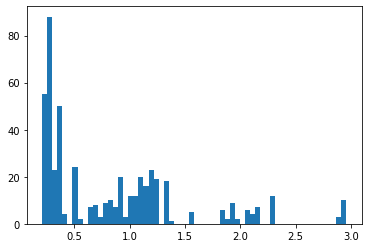

In [15]:
plt.hist(np.array(data[200, :, 1]), bins=60)

In [16]:
np.save('./gamma_pop/data_gamma_delays.npy', data)
np.save('./gamma_pop/theta_gamma_delays.npy', theta)

# fishnets models

In [3]:
data = np.load('./gamma_pop/data_gamma_delays.npy')
theta = np.load('./gamma_pop/theta_gamma_delays.npy')

In [4]:
np.max(data[:, :, 1])

8.0973835

In [5]:
full_data = np.zeros((10000,500,2))
full_data[:, :, 0] = data[:, :, 0] / 10.
full_data[:, :, 1] = data[:, :, 1] / 8.
#full_data[:, :, 2] = x1
#full_data[:, :, 3] = x2; del data
data = full_data

In [6]:
import numpy as np

n_sims = 10000
n_data = 500
n_theta = 2

tmax=10. # days
serum_max_val=4.0

theta_fid = tf.constant([2.0, 2.0], dtype=tf.float32) 
theta_fid_ = theta_fid.numpy()

# stack up the data and parameters
data = tf.convert_to_tensor(data, dtype=tf.float32)
theta = tf.convert_to_tensor(theta, dtype=tf.float32)

# construct masks
score_mask = np.ones((n_sims, n_data, n_theta))
fisher_mask = np.ones((n_sims, n_data, n_theta, n_theta))


score_mask = tf.convert_to_tensor(score_mask, dtype=tf.float32)
fisher_mask = tf.convert_to_tensor(fisher_mask, dtype=tf.float32)

In [7]:
Model = FishnetTwinNorm(n_parameters=n_theta, 
                n_inputs=2, 
                n_hidden_score=[128, 128, 128], 
                activation_score=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                n_hidden_fisher=[128, 128, 128], 
                activation_fisher=[tf.nn.elu, tf.nn.elu,  tf.nn.elu],
                optimizer=tf.keras.optimizers.Adam(lr=5e-4),
                theta_fid=theta_fid,
                priormu=tf.zeros(n_theta, dtype=tf.float32),
                priorCinv=tf.eye(n_theta, dtype=tf.float32))

In [8]:
Model.train((data, theta, score_mask, fisher_mask), lr=1e-3, epochs=100, lossfn='kl')
Model.train((data, theta, score_mask, fisher_mask), lr=5e-4, epochs=100, lossfn='kl')
Model.train((data, theta, score_mask, fisher_mask), lr=1e-4, epochs=100, lossfn='kl')
Model.train((data, theta, score_mask, fisher_mask), lr=5e-5, epochs=100, lossfn='kl')

  0%|          | 0/100 [00:00<?, ?it/s]WARNING:tensorflow:From /data80/makinen/venvs/imnndev/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py:342: MultivariateNormalFullCovariance.__init__ (from tensorflow_probability.python.distributions.mvn_full_covariance) is deprecated and will be removed after 2019-12-01.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
 23%|██▎       | 23/100 [00:59<03:00,  2.35s/it, loss=2.85]

In [ ]:
Model.train((data, theta, score_mask, fisher_mask), lr=5e-6, epochs=100, lossfn='mse')

: 

In [39]:
# model MLEs
mle, F  = Model.compute_mle_(data, score_mask, fisher_mask)

100%|██████████| 50/50 [00:03<00:00, 14.94it/s]


In [ ]:
mle = tf.convert_to_tensor(mle.numpy(), dtype=tf.float32)
mle_flow = Model.normflow.bijector(mle)

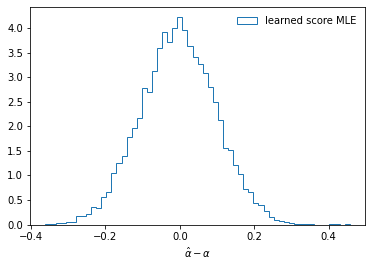

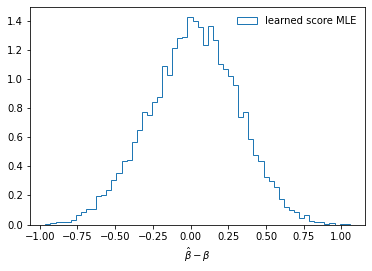

In [10]:
#plt.hist(mle_flow[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\alpha} - \alpha$')
plt.legend(frameon=False)
plt.show()


#plt.hist(mle_flow[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='flow score MLE')
plt.hist(mle[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\beta} - \beta$')
plt.legend(frameon=False)
plt.show()

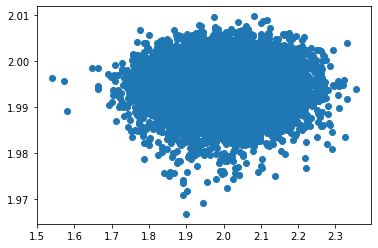

In [13]:
plt.scatter(theta[:, 0].numpy(), mle[:, 0].numpy())

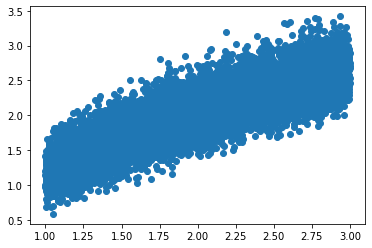

In [14]:
plt.scatter(theta[:, 1].numpy(), mle[:, 1].numpy())

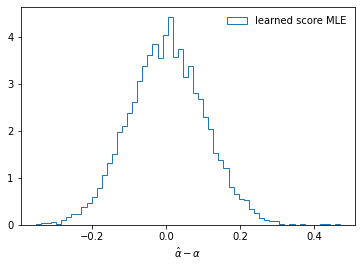

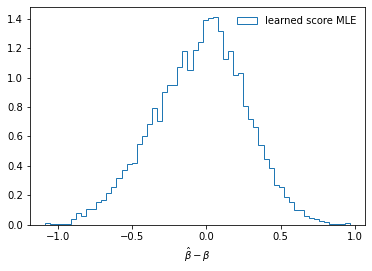

In [17]:
plt.hist(mle[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\alpha} - \alpha$')
plt.legend(frameon=False)
plt.show()

plt.hist(mle[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\beta} - \beta$')
plt.legend(frameon=False)
plt.show()

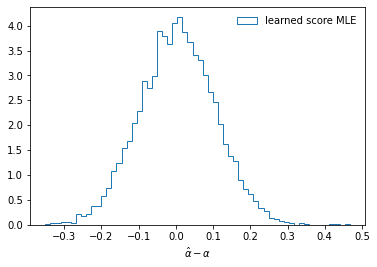

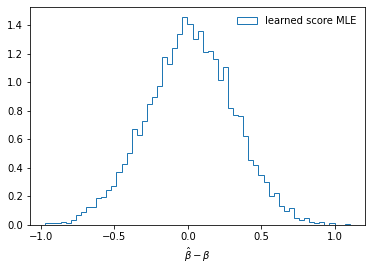

In [14]:
plt.hist(mle[:,0].numpy() - theta[:,0].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\alpha} - \alpha$')
plt.legend(frameon=False)
plt.show()

plt.hist(mle[:,1].numpy() - theta[:,1].numpy(), bins = 60, histtype='step', density=True, label='learned score MLE')
plt.xlabel(r'$\hat{\beta} - \beta$')
plt.legend(frameon=False)
plt.show()

In [11]:
np.std(theta[:, 0].numpy()), np.std(mle[:,0].numpy() - theta[:,0].numpy())

(0.10055089, 0.1005258748791685)

In [12]:
np.std(theta[:, 1]), np.std(mle[:,1].numpy() - theta[:,1].numpy())

(0.5760553, 0.2935787311273193)

(array([ 21.,  57., 125., 186., 214., 196., 202., 241., 179., 226., 210.,
        207., 217., 208., 196., 211., 216., 204., 177., 204., 221., 230.,
        208., 225., 199., 232., 200., 230., 204., 199., 224., 193., 214.,
        211., 201., 203., 219., 188., 213., 214., 207., 201., 200., 190.,
        189., 191., 186., 165., 132., 112.,  78.,  65.,  66.,  30.,  20.,
         20.,  10.,   7.,   4.,   2.]),
 array([0.4523078 , 0.47324708, 0.4941864 , 0.5151257 , 0.536065  ,
        0.5570043 , 0.5779436 , 0.5988829 , 0.6198222 , 0.6407615 ,
        0.6617008 , 0.6826401 , 0.7035794 , 0.7245187 , 0.745458  ,
        0.7663973 , 0.7873366 , 0.8082759 , 0.8292152 , 0.8501545 ,
        0.8710938 , 0.8920331 , 0.9129724 , 0.93391174, 0.95485103,
        0.9757903 , 0.9967296 , 1.017669  , 1.0386082 , 1.0595475 ,
        1.0804868 , 1.1014261 , 1.1223655 , 1.1433047 , 1.164244  ,
        1.1851833 , 1.2061226 , 1.2270619 , 1.2480012 , 1.2689406 ,
        1.2898798 , 1.3108191 , 1.3317584 , 1.

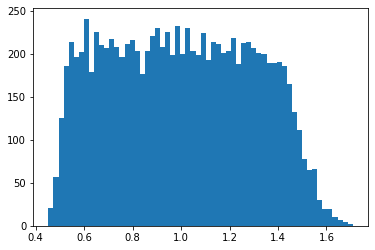

In [17]:
plt.hist(theta[:, 0].numpy() / theta[:, 1].numpy(), bins=60)

In [ ]:

key = jax.random.PRNGKey(88)

concentration = 2.0
rate = 20.
tmax = 10.

A=1.0

key,rng = jax.random.split(key)
decay_time = dist.Gamma(concentration=concentration, 
                        rate=rate).sample(key, (10000,))

key,rng = jax.random.split(key)
measurement_time = dist.Uniform(low=0.0, high=tmax).sample(key, (10000,))

key,rng = jax.random.split(key)
_lambda = A * jnp.exp(-measurement_time / decay_time )
measured_serum_level = dist.Poisson(rate=_lambda).sample(key, ())

In [ ]:
np.linspace(1, 10)

In [ ]:
rate

In [ ]:
concentration = 4.0
report_delay = 3 # days
rate = concentration / report_delay
tmax = 10.

A=1.0

key,rng = jax.random.split(key)
decay_time = dist.Gamma(concentration=concentration, 
                        rate=rate).sample(key, (10000,))
plt.hist(np.array(decay_time), bins=60)


# concentration = 2.0
# rate = 2.0 / 10

# decay_time = dist.Gamma(concentration=concentration, 
#                         rate=rate).sample(key, (10000,))
# plt.hist(np.array(decay_time), bins=60)

In [ ]:
plt.hist(np.array(decay_time), bins=60)

In [13]:
tfd = tfp.distributions
tfb = tfp.bijectors

In [15]:
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))

In [16]:
maf.distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=3.), sample_shape=[2])

AttributeError: can't set attribute

In [17]:
maf._distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=3.), sample_shape=[2])

In [26]:
F.shape

TensorShape([10000, 2, 2])

In [66]:
mydist = tfd.Sample(
        tfd.MultivariateNormalFullCovariance(loc=0., 
        covariance_matrix=F[:]), sample_shape=[])

In [67]:
mydist.sample().numpy().shape

(10000, 2)

(array([[ 2.,  8.,  7., 22., 17., 18., 16.,  7.,  2.,  1.],
        [ 0.,  0.,  1., 18., 47., 30.,  4.,  0.,  0.,  0.]]),
 array([-24.42128302, -19.23787973, -14.05447645,  -8.87107316,
         -3.68766988,   1.4957334 ,   6.67913669,  11.86253997,
         17.04594326,  22.22934654,  27.41274983]),
 <a list of 2 BarContainer objects>)

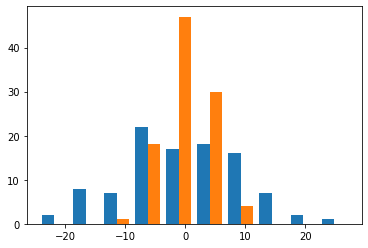

In [60]:
plt.hist(mydist.sample((100,)).numpy()[:, 0])

(array([ 2.,  2.,  4.,  9., 10.,  7.,  4.,  3.,  7.,  2.]),
 array([-1.1977313 , -0.96494275, -0.73215425, -0.49936578, -0.2665773 ,
        -0.0337888 ,  0.19899969,  0.43178818,  0.66457665,  0.89736515,
         1.1301537 ], dtype=float32),
 <BarContainer object of 10 artists>)

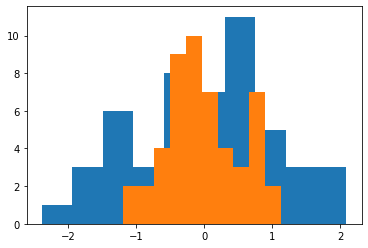

In [25]:
maf = tfd.TransformedDistribution(
    distribution=tfd.Sample(
        tfd.Normal(loc=0., scale=1.), sample_shape=[2]),
    bijector=tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[512, 512])))


plt.hist(maf.distribution.sample((50,)).numpy()[:, 0])


maf._distribution = tfd.Sample(
        tfd.Normal(loc=0., scale=0.5), sample_shape=[2])
plt.hist(maf.distribution.sample((50,)).numpy()[:, 0])